In [28]:
import json
import logging
import statistics
import sys
import os
from copy import deepcopy

import matplotlib.pyplot as plt
from tqdm import tqdm
from xopen import xopen

script_dir = os.getcwd()
parent_dir = os.path.dirname(script_dir)
src_dir = os.path.join(parent_dir, 'src')
sys.path.append(src_dir)

from lost_in_the_middle.metrics import best_subspan_em

In [101]:
def load_all_examples(model_predictions_file, default_gold_index = -1): # set gold index to -1 if randomized
    all_examples = []
    examples_by_new_gold_index = {}

    with xopen(model_predictions_file) as fin: 
            for line in tqdm(fin):
                input_example = json.loads(line)
                all_examples.append(input_example)
                new_gold_index = input_example.get("new_gold_index")
                if new_gold_index is not None:
                    examples_by_new_gold_index.setdefault(new_gold_index, []).append(input_example)
    
    return all_examples, examples_by_new_gold_index

In [102]:
def calculate_scores(all_examples):
    example_scores = []
    for i, example in enumerate(all_examples):
        score = best_subspan_em(prediction=example['model_answer'], ground_truths=example['answers'])
        all_examples[i]['score'] = score
        example_scores.append(score)

    average_score = statistics.mean(example_scores)
    return average_score

In [112]:
def plot_scores_by_gold_index(avg_scores_by_gold_index):
    gold_indexes = list(avg_scores_by_gold_index.keys())
    average_scores = list(avg_scores_by_gold_index.values())

    plt.figure(figsize=(10, 6))
    plt.plot(gold_indexes, average_scores, marker='o')
    plt.xticks(gold_indexes)
    plt.title('Average Scores by Gold Index')
    plt.xlabel('Gold Index')
    plt.ylabel('Average Score')
    plt.grid(True)
    plt.show()

Closed-Book Experiment

10 Document Experiment (from LITM paper)

In [86]:
avg_scores_by_gold_index = {}

In [87]:
for i in [0,4,9]:
    gold_at_i_file = f'../qa_predictions/10_total_documents/nq-open-gold_at_{i}-uf-llama-predictions.jsonl.gz'
    all_examples, _ = load_all_examples(gold_at_i_file)
    gold_at_i_average_score = calculate_scores(gold_at_i_examples)
    print(f"Gold at {i}, UF LLaMa 2 7B, Average Score: {gold_at_i_average_score}")

    avg_scores_by_gold_index[i] = gold_at_i_average_score

2655it [00:00, 96386.15it/s]


Gold at 0, UF LLaMa 2 7B, Average Score: 0.6214689265536724


2655it [00:00, 70038.72it/s]


Gold at 4, UF LLaMa 2 7B, Average Score: 0.5435028248587571


2655it [00:00, 75740.87it/s]

Gold at 9, UF LLaMa 2 7B, Average Score: 0.47156308851224105


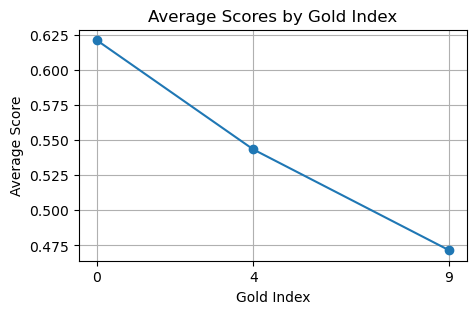

In [88]:
plot_scores_by_gold_index(avg_scores_by_gold_index)

20 Document Experiment (from LITM paper)

In [89]:
avg_scores_by_gold_index = {}

In [90]:
for i in [0,4,9,14,19]:
    gold_at_i_file = f'../qa_predictions/20_total_documents/nq-open-gold_at_{i}-uf-llama-predictions.jsonl.gz'
    gold_at_i_examples = load_all_examples(gold_at_i_file)
    gold_at_i_average_score = calculate_scores(gold_at_i_examples)
    print(f"Gold at {i}, UF LLaMa 2 7B, Average Score: {gold_at_i_average_score}")

    avg_scores_by_gold_index[i] = gold_at_i_average_score

2655it [00:00, 71849.00it/s]


Gold at 0, UF LLaMa 2 7B, Average Score: 0.45160075329566857


2655it [00:00, 29012.98it/s]


Gold at 4, UF LLaMa 2 7B, Average Score: 0.3879472693032015


2655it [00:00, 67675.14it/s]


Gold at 9, UF LLaMa 2 7B, Average Score: 0.37212806026365347


2655it [00:00, 94864.65it/s]


Gold at 14, UF LLaMa 2 7B, Average Score: 0.5717514124293785


2655it [00:00, 81435.95it/s]


Gold at 19, UF LLaMa 2 7B, Average Score: 0.6105461393596987


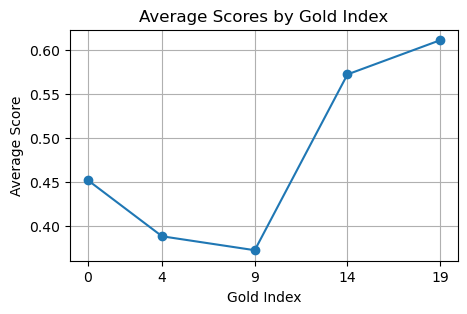

In [92]:
plot_scores_by_gold_index(avg_scores_by_gold_index)

30 Document Experiment (Randomized Gold Index)

2655it [00:00, 88375.77it/s]


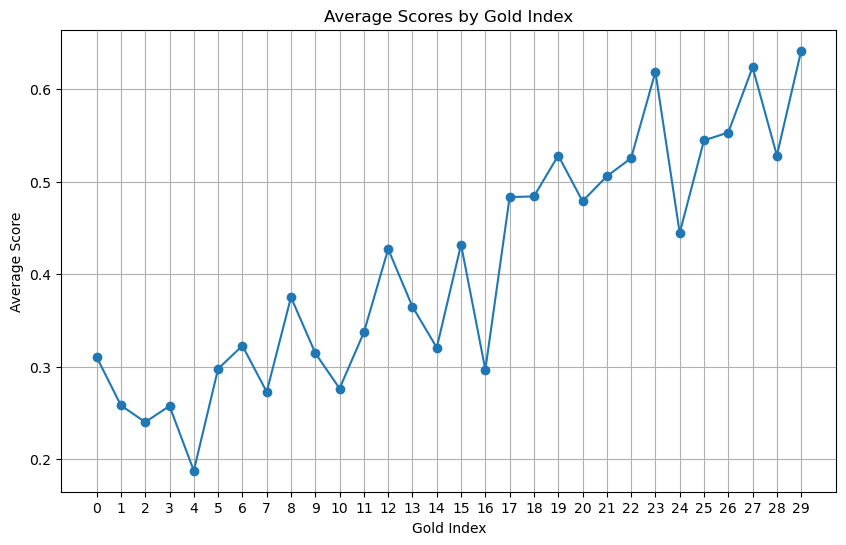

New Gold Index 0: 87 examples
New Gold Index 1: 93 examples
New Gold Index 2: 75 examples
New Gold Index 3: 101 examples
New Gold Index 4: 80 examples
New Gold Index 5: 84 examples
New Gold Index 6: 93 examples
New Gold Index 7: 77 examples
New Gold Index 8: 104 examples
New Gold Index 9: 89 examples
New Gold Index 10: 76 examples
New Gold Index 11: 92 examples
New Gold Index 12: 89 examples
New Gold Index 13: 85 examples
New Gold Index 14: 78 examples
New Gold Index 15: 88 examples
New Gold Index 16: 91 examples
New Gold Index 17: 89 examples
New Gold Index 18: 93 examples
New Gold Index 19: 89 examples
New Gold Index 20: 94 examples
New Gold Index 21: 89 examples
New Gold Index 22: 99 examples
New Gold Index 23: 97 examples
New Gold Index 24: 90 examples
New Gold Index 25: 90 examples
New Gold Index 26: 85 examples
New Gold Index 27: 77 examples
New Gold Index 28: 89 examples
New Gold Index 29: 92 examples


In [125]:
truncated_llama_file = '../qa_predictions/30_total_documents/nq-open-randomized-uf-llama-predictions.jsonl.gz'
all_examples, examples_by_new_gold_index = load_all_examples(truncated_llama_file)

metric_values_by_new_gold_index = {}
counts_by_new_gold_index = {}

for new_gold_index in sorted(examples_by_new_gold_index.keys()):
    metrics = calculate_scores(examples_by_new_gold_index[new_gold_index])
    metric_values_by_new_gold_index[new_gold_index] = metrics

    # Count the number of examples for this new_gold_index
    count = len(examples_by_new_gold_index[new_gold_index])
    counts_by_new_gold_index[new_gold_index] = count

# Plot the scores
plot_scores_by_gold_index(metric_values_by_new_gold_index)

# Print the counts
for new_gold_index, count in counts_by_new_gold_index.items():
    print(f"New Gold Index {new_gold_index}: {count} examples")


50 Document Experiment (Randomized Gold Index)

2655it [00:00, 91436.57it/s]
2655it [00:00, 67483.62it/s]
2655it [00:00, 70488.27it/s]
2655it [00:00, 64993.62it/s]
2655it [00:00, 72692.76it/s]


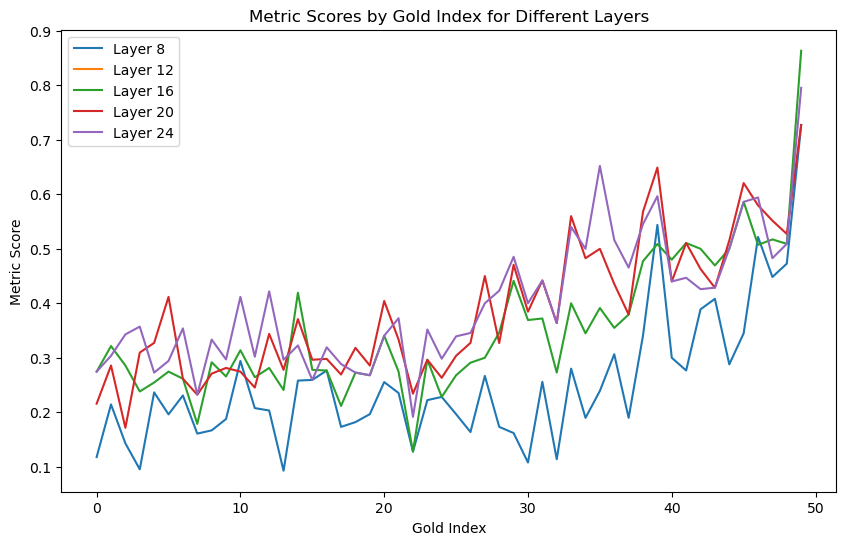

In [121]:
layer_files = {
    8: '../qa_predictions/50_total_documents/nq-open-randomized-uf-llama-predictions-8.jsonl.gz',
    12: '../qa_predictions/50_total_documents/nq-open-randomized-uf-llama-predictions-12.jsonl.gz',
    16: '../qa_predictions/50_total_documents/nq-open-randomized-uf-llama-predictions-16.jsonl.gz',
    20: '../qa_predictions/50_total_documents/nq-open-randomized-uf-llama-predictions-20.jsonl.gz',
    24: '../qa_predictions/50_total_documents/nq-open-randomized-uf-llama-predictions-24.jsonl.gz'
}

metrics_by_layer = {}

for layer, file_path in layer_files.items():
    all_examples, examples_by_new_gold_index = load_all_examples(file_path)
    metric_values_by_new_gold_index = {}

    for new_gold_index in sorted(examples_by_new_gold_index.keys()):
        metrics = calculate_scores(examples_by_new_gold_index[new_gold_index])
        metric_values_by_new_gold_index[new_gold_index] = metrics

    metrics_by_layer[layer] = metric_values_by_new_gold_index

# Plotting
plt.figure(figsize=(10, 6))

for layer, metrics in metrics_by_layer.items():
    gold_indices = list(metrics.keys())
    scores = [metrics[gold_index] for gold_index in gold_indices]
    plt.plot(gold_indices, scores, label=f'Layer {layer}')

plt.xlabel('Gold Index')
plt.ylabel('Metric Score')
plt.title('Metric Scores by Gold Index for Different Layers')
plt.legend()
plt.show()

2655it [00:00, 76833.60it/s]


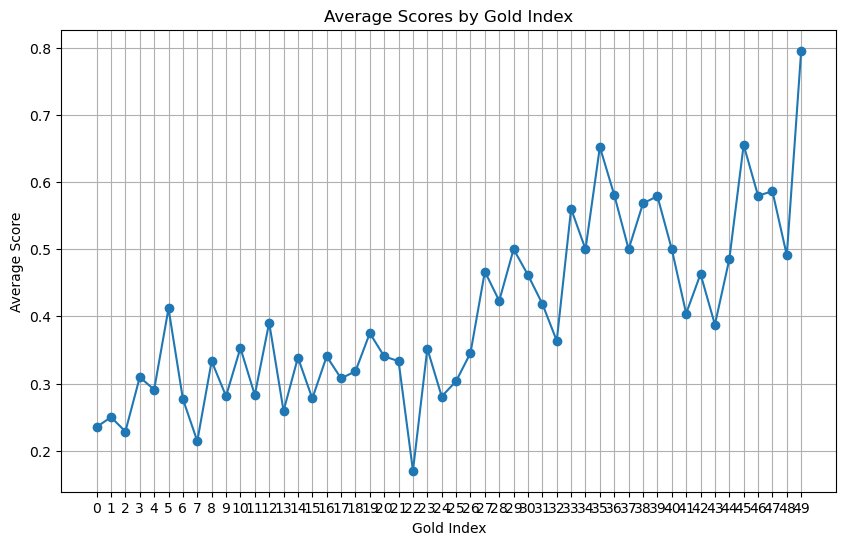

In [120]:
truncated_llama_file = f'../qa_predictions/50_total_documents/nq-open-randomized-llama-predictions.jsonl.gz'
all_examples, examples_by_new_gold_index = load_all_examples(truncated_llama_file)

metric_values_by_new_gold_index = {}
for new_gold_index in sorted(examples_by_new_gold_index.keys()):
            metrics = calculate_scores(examples_by_new_gold_index[new_gold_index])
            metric_values_by_new_gold_index[new_gold_index] = metrics

plot_scores_by_gold_index(metric_values_by_new_gold_index)

In [126]:
truncated_llama_file = f'../qa_predictions/open_oracle/unlimiformer_llama_2_7b_chat_gptq/predictions.jsonl.gz'
all_examples, examples_by_new_gold_index = load_all_examples(truncated_llama_file)

10it [00:00, 332.88it/s]
